In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
#read dataset
df = pd.read_csv("dataset.csv")

C:\Users\HakanKulluce-PC\AppData\Local\Temp\ipykernel_7416\3064147466.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")


In [3]:
df.head()

,restaurant_link,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,...,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,keywords
0,g10001637-d10002227,Le 147,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"10 Maison Neuve, 87510 Saint-Jouvent France",45.961674,1.169131,...,2.0,0.0,0.0,0.0,0.0,4.0,4.5,4.0,NaN,NaN
1,g10001637-d14975787,Le Saint Jouvent,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"16 Place de l Eglise, 87510 Saint-Jouvent France",45.957040,1.205480,...,2.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,g10002858-d4586832,Au Bout du Pont,"[""Europe"", ""France"", ""Centre-Val de Loire"", ""B...",France,Centre-Val de Loire,Berry,Rivarennes,"2 rue des Dames, 36800 Rivarennes France",46.635895,1.386133,...,3.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,g10002986-d3510044,Le Relais de Naiade,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Lacelle,"9 avenue Porte de la Correze 19170, 19170 Lace...",45.642610,1.824460,...,1.0,0.0,0.0,0.0,0.0,4.5,4.5,4.5,NaN,NaN
4,g10022428-d9767191,Relais Du MontSeigne,"[""Europe"", ""France"", ""Occitanie"", ""Aveyron"", ""...",France,Occitanie,Aveyron,Saint-Laurent-de-Levezou,"route du Montseigne, 12620 Saint-Laurent-de-Le...",44.208860,2.960470,...,4.0,7.0,0.0,0.0,0.0,4.5,4.5,4.5,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083397 entries, 0 to 1083396
Data columns (total 42 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   restaurant_link                    1083397 non-null  object 
 1   restaurant_name                    1083397 non-null  object 
 2   original_location                  1083397 non-null  object 
 3   country                            1083397 non-null  object 
 4   region                             1033074 non-null  object 
 5   province                           742765 non-null   object 
 6   city                               682712 non-null   object 
 7   address                            1083397 non-null  object 
 8   latitude                           1067607 non-null  float64
 9   longitude                          1067607 non-null  float64
 10  claimed                            1081555 non-null  object 
 11  awards                  

In [5]:
total_column_list = df.columns.tolist()
print(total_column_list)

['restaurant_link', 'restaurant_name', 'original_location', 'country', 'region', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'awards', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_level', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'original_open_hours', 'open_days_per_week', 'open_hours_per_week', 'working_shifts_per_week', 'avg_rating', 'total_reviews_count', 'default_language', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'terrible', 'food', 'service', 'value', 'atmosphere', 'keywords']


# Data Cleaning

### Item 1

I will iterate over columns by checking different types existence, in case lenght is more than 0, that means there are mixed data types in that column

In [6]:
mixed_type_columns=[]
for col in df.columns:
    mixed_data_types = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis=1)
    if len(df[mixed_data_types]) > 0:
        mixed_type_columns.append(col)
print(mixed_type_columns)

['region', 'province', 'city', 'claimed', 'awards', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_level', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'original_open_hours', 'default_language', 'keywords']


### Item 2

To be able to count row, I wanted to remove above mixed data columns, for the mixed data columns I couldnt generate row counts

In [7]:
#drop mixed columns from total column list
non_mixed_dtype_column_lst = [ele for ele in total_column_list if ele not in mixed_type_columns]
print(non_mixed_dtype_column_lst)

['restaurant_link', 'restaurant_name', 'original_location', 'country', 'address', 'latitude', 'longitude', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'open_days_per_week', 'open_hours_per_week', 'working_shifts_per_week', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'terrible', 'food', 'service', 'value', 'atmosphere']


Below, I created empty dict, and while iterating over non_mixed_dtype_column_lst I counted total row and wrote into dict

In [8]:
counts_per_dtype = {}

# Iterate over each column in the DataFrame
for column in non_mixed_dtype_column_lst:
    # Group the data by data type and count the number of rows in each group
    counts = df[column].groupby(df[column].apply(type)).count()
    counts_per_dtype[column] = counts

print(counts_per_dtype)

{'restaurant_link': restaurant_link
<class 'str'>    1083397
Name: restaurant_link, dtype: int64, 'restaurant_name': restaurant_name
<class 'str'>    1083397
Name: restaurant_name, dtype: int64, 'original_location': original_location
<class 'str'>    1083397
Name: original_location, dtype: int64, 'country': country
<class 'str'>    1083397
Name: country, dtype: int64, 'address': address
<class 'str'>    1083397
Name: address, dtype: int64, 'latitude': latitude
<class 'float'>    1067607
Name: latitude, dtype: int64, 'longitude': longitude
<class 'float'>    1067607
Name: longitude, dtype: int64, 'vegetarian_friendly': vegetarian_friendly
<class 'str'>    1083397
Name: vegetarian_friendly, dtype: int64, 'vegan_options': vegan_options
<class 'str'>    1083397
Name: vegan_options, dtype: int64, 'gluten_free': gluten_free
<class 'str'>    1083397
Name: gluten_free, dtype: int64, 'open_days_per_week': open_days_per_week
<class 'float'>    593832
Name: open_days_per_week, dtype: int64, 'open

### Item 3

I will drop rows where it has null cells

In [9]:
# drop null values from dataframe
dropped_na_df=df.dropna()

In [10]:
#Re-running first item to detect mixed_type_columns
mixed_type_columns=[]
for col in dropped_na_df.columns:
    mixed_data_types = (dropped_na_df[[col]].applymap(type) != dropped_na_df[[col]].iloc[0].apply(type)).any(axis=1)
    if len(dropped_na_df[mixed_data_types]) > 0:
        mixed_type_columns.append(col)
print("mixed_dtype_columns:",mixed_type_columns)

mixed_dtype_columns: []


As we see, dropping null rows helped to resolve mixed data types

# Data Understanding

### Item 1

In [11]:
df_1_rating = dropped_na_df[["food", "service", "value", "atmosphere", "avg_rating"]]
df_2_review = dropped_na_df[["excellent", "very_good", "average", "poor", "terrible", "total_reviews_count", "reviews_count_in_default_language"]]

In [12]:
corr_matrix = df_1_rating.corrwith(other=df_2_review, axis=1)

In [13]:
pd.concat([df_1_rating, df_2_review], axis=1, keys=['df_1_rating', 'df_2_review']).corr().loc['df_2_review', 'df_1_rating']

,food,service,value,atmosphere,avg_rating
excellent,0.172486,0.148564,0.065835,0.167678,0.173696
very_good,-0.156339,-0.186690,-0.244713,-0.062866,-0.180352
average,-0.263905,-0.302050,-0.367967,-0.143791,-0.307421
poor,-0.338109,-0.388396,-0.440628,-0.208236,-0.391741
terrible,-0.397746,-0.446877,-0.444019,-0.262289,-0.451994
total_reviews_count,0.039960,-0.006927,-0.073920,0.097625,0.028484
reviews_count_in_default_language,0.012198,-0.019469,-0.096617,0.056696,-0.002495


<AxesSubplot:>

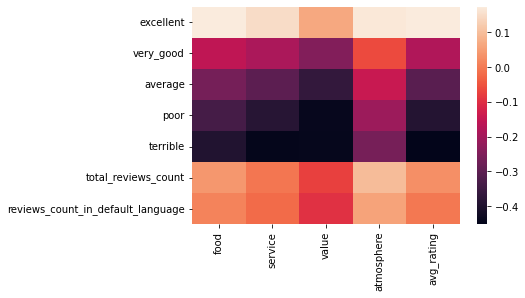

In [14]:
#heatmap
sns.heatmap(pd.concat([df_1_rating, df_2_review], axis=1, keys=['df_1_rating', 'df_2_review']).corr().loc['df_2_review', 'df_1_rating'])

By looking to chart and map;\
There is a positive correlation between food <-> excellent,\
&emsp;&emsp;&emsp;&emsp;negatiive correlation between food <-> terrible,\
There is a positive correlation between service <-> excellent,\
&emsp;&emsp;&emsp;&emsp;negatiive correlation between service <-> terrible,\
There is a negatiive correlation between value <-> terrible,\
&emsp;&emsp;&emsp;&emsp;!We can not say there is positive correaltion of "value"\
There is a no positive and negative correaltion of "atmosphere"\
There is a positive correlation between avg_rating <-> excellent,\
&emsp;&emsp;&emsp;&emsp;negatiive correlation between avg_rating <-> terrible,\
&emsp;&emsp;We can say that average rating effecting excellent review with highest correaltion. That means people aggree with others opininon about restaurant rating

### Item 2

To see difference between vegetarian-friendly restaurants and non-vegetarian ones I want to check its "avg_rating" average, another point that I selected "avg_rating" is that it has correlation with positive-negative reviews

In [15]:
vegetarian_friendly = dropped_na_df.loc[df["vegetarian_friendly"]=="Y","avg_rating"].mean()
non_vegetarian_friendly = dropped_na_df.loc[df["vegetarian_friendly"]=="N","avg_rating"].mean()
print("vegetarian_friendly_avg_rating",vegetarian_friendly)
print("non_vegetarian_friendly_avg_rating",non_vegetarian_friendly)


vegetarian_friendly_avg_rating 4.341745283018868
non_vegetarian_friendly_avg_rating 4.368421052631579


We can say that non_vegetarian_friendly restaurants have average higher rate than vegetarian_friendly restaurant

### Item 3

I want to check expensive cuisines firstly from dropped_na_df, and then I will check from raw df. I want to split price_range to generate two columns "price_lowest" and "price_highest"

In [16]:
#highest price from Nan values dropped dataframe
dropped_na_df[['price_lowest', 'price_highest']] = dropped_na_df.price_range.str.split("-", expand = True)
highest_price_from_dropped_df= dropped_na_df[["restaurant_name","price_highest"]].sort_values("price_highest", ascending=False)
print(highest_price_from_dropped_df)

                      restaurant_name price_highest
376546              El Novillo Precoz          €999
1021972                    A Caravela           €99
608576                 The White Hart           €93
633235   The Torridon 1887 Restaurant           €92
543100                        Rafters           €92
...                               ...           ...
307436                      Mamma Mia           €10
469953                       Domu Mia           €10
982336              Alibaba Beach Bar           €10
217412                   Il Pescatore        CHF 30
217566       Gasthof Goldener Greifen        CHF 22

[2177 rows x 2 columns]


C:\Users\HakanKulluce-PC\AppData\Local\Temp\ipykernel_7416\3324462781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_na_df[['price_lowest', 'price_highest']] = dropped_na_df.price_range.str.split("-", expand = True)
C:\Users\HakanKulluce-PC\AppData\Local\Temp\ipykernel_7416\3324462781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_na_df[['price_lowest', 'price_highest']] = dropped_na_df.price_range.str.split("-", expand = True)


It looks significantly expensive cuisine is "El Novillo Precoz" that its highest price 999€ 

In [17]:
#highest price from raw dataframe(non-dropped)
df[['price_lowest', 'price_highest']] = df.price_range.str.split("-", expand = True)
highest_price_from_raw_df= df[["restaurant_name","price_highest"]].sort_values(["price_highest"], ascending=False).head(n=30)
print(highest_price_from_raw_df)

                                           restaurant_name price_highest
839196                                 Osteria Tuttapposto      €999,999
376546                                   El Novillo Precoz          €999
64797                                            Lanka bar          €999
1059825                                Viihdemaailma Ilona          €999
950394                                           La Storia          €999
793356                                       Mythos Garden          €999
688033                                           Gelato In          €999
710750          XinZhonghua - Ristorante cinese giapponese          €999
654805                              Il Sapore dei Miracoli          €999
341895                                     Cocodrilo's Bar          €999
454867            Restaurante El Mirador de Puerto Antilla          €999
28504                            Les Doux Secrets d'Hélène          €999
398850                           Restaurante San Fr

We can say that prices that are higher than 99€ significantly more expensive than the others

# Business-specific

### Item 1

Firstly I want to add value counts of "gluten_free" to dataset.csv dataframe as I call df

In [18]:
df['value_count'] = df.groupby(['city', 'gluten_free'])['gluten_free'].transform('count')

In [19]:
city_area_pop_df = pd.read_csv("europe_capitals_population_and_area.csv", delimiter=";",decimal=',')
city_area_pop_df.rename(columns = {'Area in km2 ':'Area_in_km2'}, inplace = True)
city_area_pop_df.rename(columns = {'City':'city'}, inplace = True)
print(city_area_pop_df)

    CityNo        city      Country  Population  Area_in_km2
0        1   Amsterdam   Netherland      851573       219.32
1        2      Athens       Greece      664046      2929.00
2        4   Barcelona        Spain     1620809       101.40
3        4      Berlin      Germany     3711930       891.70
4        5  Bratislava     Slovakia      424428       367.60
5        6    Brussels      Belgium     1191604       161.38
6        7    Budapest      Hungary     1779361       525.20
7        8  Copenhagen      Denmark      602481        88.25
8        9      Dublin      Ireland      527612       115.00
9       10   Edinburgh     Scotland      482005       264.00
10      11      Geneva  Switzerland      198979        15.92
11      12     Hamburg      Germany     1822445       755.00
12      13    Helsinki      Finland      631695       184.50
13      14      Krakow       Poland      765320       327.00
14      15      Lisbon     Portugal      504718       100.00
15      16   Ljubljana  

This is the city_area_pop_df, where I renamed 2 columns

I want to merge dataset.csv and europe_capitals_population_and_area.csv with common column "city"

In [20]:
merged_df = pd.merge(city_area_pop_df, df, on='city', how="right")

I created "pop_density" column from "Population" and "Area_in_km2" , then I generated dropped_merged_df where "pop_density" not calculated (Nan)\
I will use dropped_merged_df after this step

In [21]:
merged_df.loc[merged_df["Area_in_km2"]!="",'pop_density']=merged_df["Population"] / merged_df["Area_in_km2"]

dropped_merged_df = merged_df[merged_df['pop_density'].notna()]
dropped_merged_df = dropped_merged_df[["city", "Population", "Area_in_km2","gluten_free","value_count","pop_density"]].drop_duplicates()

In [22]:
dropped_merged_df[["city", "Population", "Area_in_km2","gluten_free","value_count","pop_density"]].sort_values("pop_density",ascending=False)
dropped_merged_df.reset_index()

,index,city,Population,Area_in_km2,gluten_free,value_count,pop_density
0,38542,Paris,2206488.0,105.40,N,17547.0,20934.421252
1,38544,Paris,2206488.0,105.40,Y,582.0,20934.421252
2,83160,Lyon,506615.0,47.87,N,2876.0,10583.141842
3,83164,Lyon,506615.0,47.87,Y,54.0,10583.141842
4,163488,Amsterdam,851573.0,219.32,N,3730.0,3882.787707
5,163496,Amsterdam,851573.0,219.32,Y,622.0,3882.787707
6,179146,Zurich,409241.0,87.93,N,1.0,4654.168088
7,211695,Munich,1456039.0,310.43,Y,256.0,4690.393970
8,211696,Munich,1456039.0,310.43,N,3252.0,4690.393970
9,308152,Vienna,1889083.0,414.60,N,4158.0,4556.398939


Because of Zurich doesnt have a gluten_free restaurant in dataset Im adding dummy row where 'gluten_free':'Y' and 'value_count':0

In [23]:
new_row = {'city':'Zurich', 'Population':409241.0, 'Area_in_km2':87.93, 'gluten_free':'Y', 'value_count':0, 'pop_density':4654.168088}
#append row to the dataframe
dropped_merged_df = dropped_merged_df.append(new_row, ignore_index=True)
dropped_merged_df

C:\Users\HakanKulluce-PC\AppData\Local\Temp\ipykernel_7416\2463584795.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dropped_merged_df = dropped_merged_df.append(new_row, ignore_index=True)


,city,Population,Area_in_km2,gluten_free,value_count,pop_density
0,Paris,2206488.0,105.40,N,17547.0,20934.421252
1,Paris,2206488.0,105.40,Y,582.0,20934.421252
2,Lyon,506615.0,47.87,N,2876.0,10583.141842
3,Lyon,506615.0,47.87,Y,54.0,10583.141842
4,Amsterdam,851573.0,219.32,N,3730.0,3882.787707
5,Amsterdam,851573.0,219.32,Y,622.0,3882.787707
6,Zurich,409241.0,87.93,N,1.0,4654.168088
7,Munich,1456039.0,310.43,Y,256.0,4690.393970
8,Munich,1456039.0,310.43,N,3252.0,4690.393970
9,Vienna,1889083.0,414.60,N,4158.0,4556.398939


In [24]:
capital_list = dropped_merged_df["city"].tolist()
print("unique_capital list",capital_list)

unique_capital list ['Paris', 'Paris', 'Lyon', 'Lyon', 'Amsterdam', 'Amsterdam', 'Zurich', 'Munich', 'Munich', 'Vienna', 'Vienna', 'Madrid', 'Madrid', 'Rome', 'Rome', 'Milan', 'Milan', 'Dublin', 'Dublin', 'Stockholm', 'Stockholm', 'Athens', 'Athens', 'Lisbon', 'Lisbon', 'Bratislava', 'Bratislava', 'Prague', 'Prague', 'Budapest', 'Budapest', 'Helsinki', 'Helsinki', 'Copenhagen', 'Copenhagen', 'Zurich']


For percentage calculations Im assigning "value_count" as integer

In [25]:
dropped_merged_df["value_count"] = dropped_merged_df["value_count"].astype(int)

In [26]:
dropped_merged_df

,city,Population,Area_in_km2,gluten_free,value_count,pop_density
0,Paris,2206488.0,105.40,N,17547,20934.421252
1,Paris,2206488.0,105.40,Y,582,20934.421252
2,Lyon,506615.0,47.87,N,2876,10583.141842
3,Lyon,506615.0,47.87,Y,54,10583.141842
4,Amsterdam,851573.0,219.32,N,3730,3882.787707
5,Amsterdam,851573.0,219.32,Y,622,3882.787707
6,Zurich,409241.0,87.93,N,1,4654.168088
7,Munich,1456039.0,310.43,Y,256,4690.393970
8,Munich,1456039.0,310.43,N,3252,4690.393970
9,Vienna,1889083.0,414.60,N,4158,4556.398939


I will calculate city of percentage ratio of restaurants that has gluten_free

In [27]:
for city in capital_list:
    yes_value_count = int(dropped_merged_df.loc[(dropped_merged_df["city"]==city)
                                          &(dropped_merged_df["gluten_free"]=="Y"),"value_count"].astype(int))
    no_value_count  = int(dropped_merged_df.loc[(dropped_merged_df["city"]==city)
                                          &(dropped_merged_df["gluten_free"]=="N"),"value_count"].astype(int))
    percentage_value_count = (yes_value_count/no_value_count)*100
    dropped_merged_df.loc[dropped_merged_df["city"]==city,"percentage_value_count"]= int(percentage_value_count)
dropped_merged_df.sort_values(by=["pop_density", "percentage_value_count"], inplace=True, ascending = [False, False])
dropped_merged_df

,city,Population,Area_in_km2,gluten_free,value_count,pop_density,percentage_value_count
0,Paris,2206488.0,105.40,N,17547,20934.421252,3.0
1,Paris,2206488.0,105.40,Y,582,20934.421252,3.0
2,Lyon,506615.0,47.87,N,2876,10583.141842,1.0
3,Lyon,506615.0,47.87,Y,54,10583.141842,1.0
15,Milan,1370074.0,181.76,N,7228,7537.819102,15.0
16,Milan,1370074.0,181.76,Y,1154,7537.819102,15.0
33,Copenhagen,602481.0,88.25,Y,251,6826.980170,11.0
34,Copenhagen,602481.0,88.25,N,2194,6826.980170,11.0
11,Madrid,3141991.0,604.30,N,10766,5199.389376,12.0
12,Madrid,3141991.0,604.30,Y,1368,5199.389376,12.0


In [28]:
dropped_merged_df["gluten_free_per_pop_density"]= dropped_merged_df["percentage_value_count"] / dropped_merged_df["pop_density"]
dropped_merged_df.sort_values(by=["gluten_free_per_pop_density"], inplace=True, ascending = [False])
dropped_merged_df

,city,Population,Area_in_km2,gluten_free,value_count,pop_density,percentage_value_count,gluten_free_per_pop_density
22,Athens,664046.0,2929.00,Y,271,226.714237,10.0,0.044108
21,Athens,664046.0,2929.00,N,2644,226.714237,10.0,0.044108
14,Rome,2868782.0,1285.00,Y,1654,2232.515175,15.0,0.006719
13,Rome,2868782.0,1285.00,N,10949,2232.515175,15.0,0.006719
18,Dublin,527612.0,115.00,Y,596,4587.930435,27.0,0.005885
17,Dublin,527612.0,115.00,N,2153,4587.930435,27.0,0.005885
25,Bratislava,424428.0,367.60,N,1333,1154.591948,5.0,0.004331
26,Bratislava,424428.0,367.60,Y,67,1154.591948,5.0,0.004331
4,Amsterdam,851573.0,219.32,N,3730,3882.787707,16.0,0.004121
5,Amsterdam,851573.0,219.32,Y,622,3882.787707,16.0,0.004121


I would open a restaurant where "gluten_free_per_pop_density" value is lowest. So these would be \
"Zurich", "Lyon", "Paris", "Munich","Prague" in order 

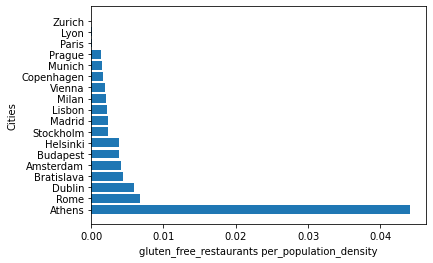

In [35]:
x = dropped_merged_df["city"]
y = dropped_merged_df["gluten_free_per_pop_density"]
plt.barh(x,y)
plt.xlabel("gluten_free_restaurants per_population_density")
plt.ylabel("Cities")
plt.show()

# Bonus

In [30]:
polygon_data = pd.read_json("paris_bounding_polygon.json")
polygon_data_df = pd.DataFrame(polygon_data)
polygon_data_df.rename(columns = {0:'longitude'}, inplace = True)
polygon_data_df.rename(columns = {1:'latitude'}, inplace = True)

In [31]:
polygon_data_df.head()

,Longitude,Latitude
0,2.224169,48.853442
1,2.224161,48.853478
2,2.224143,48.853578
3,2.224135,48.853654
4,2.224129,48.853759


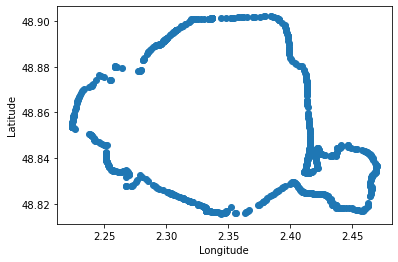

In [37]:
a = polygon_data_df["longitude"]
b = polygon_data_df["latitude"]
plt.scatter(a,b)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

Restaurants in Paris with Italian cuisine

In [40]:
ita_rest_in_paris = df.loc[(df["city"]=="Paris")
                       &(df["cuisines"]=="Italian"),["longitude","latitude"]]

In [42]:
ita_rest_in_paris.head()

,longitude,latitude
38542,2.305100,48.846660
38569,2.333324,48.894110
38607,2.345860,48.871420
38672,2.305515,48.869675
38718,2.349713,48.841766


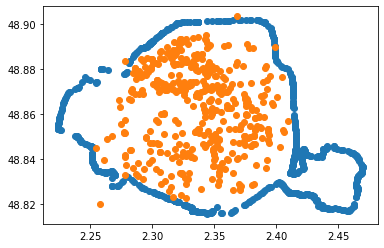

In [49]:
c=ita_rest_in_paris["longitude"]
d=ita_rest_in_paris["latitude"]
plt.scatter(a,b)
plt.scatter(c,d)
plt.show()

To open new Italian restaurant I would select these 2 areas

<img src="./bonus_challenge_2023-01-31_143212.png" />